# Teaser Figure

In [1]:
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib import patches
import jax.numpy as jnp
import numpy as np
import exponax as ex
import jax
import cmasher

from v4dv import felix_cmap_hack, render, viewer

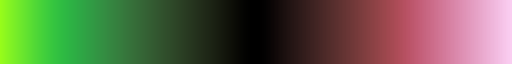

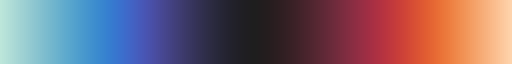

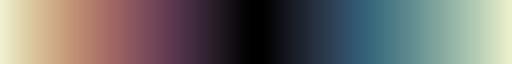

In [2]:
import seaborn as sns

sns.set_theme()
cmap_linear = cmasher.watermelon
cmap_nonlinear = sns.color_palette("icefire", as_cmap=True)
cmap_diff = cmasher.copper_s
display(cmap_linear)
display(cmap_nonlinear)
display(cmap_diff)

In [3]:
def symmetric_min_max(arr):
    vmin = arr.min().item()
    vmax = arr.max().item()
    absmax = max(abs(vmin), abs(vmax))
    return -absmax, absmax

# 1D Cases

In [4]:
time_steps_1d = 200

### Fisher-KPP

$$
\frac{\partial u}{\partial t} = \nu \Delta u + r u (1 - u)
$$

2024-06-04 12:59:46.754149: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


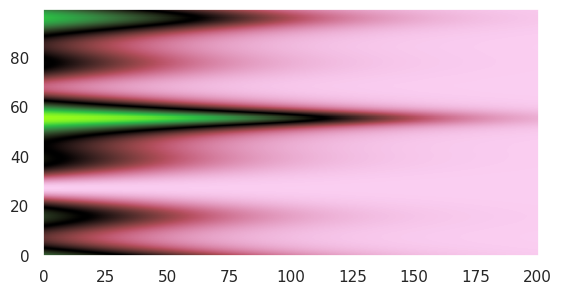

In [5]:
DOMAIN_EXTENT = 10.0
NUM_POINTS = 100
DT = 0.003
DIFFUSIVITY = 0.05
REACTIVITY = 10.0

fisher_kpp_stepper = ex.reaction.FisherKPP(
    1, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=DIFFUSIVITY, reactivity=REACTIVITY
)

ic_gen = ex.ic.ClampingICGenerator(ex.ic.RandomTruncatedFourierSeries(1), limits=(0, 1))
u_0 = ic_gen(100, key=jax.random.PRNGKey(0))

fisher_kpp_trj_1d = ex.rollout(fisher_kpp_stepper, time_steps_1d, include_init=True)(
    u_0
)

vmin, vmax = symmetric_min_max(fisher_kpp_trj_1d)
plt.imshow(
    fisher_kpp_trj_1d[:, 0, :].T * 2 - 1,
    origin="lower",
    cmap=cmap_linear,
    interpolation="bilinear",
    vmin=vmin,
    vmax=vmax,
)
plt.grid(False)

### Dispersion

$$ \frac{\partial u}{\partial t} + \xi \frac{\partial^3 u}{\partial x^3} = 0 $$

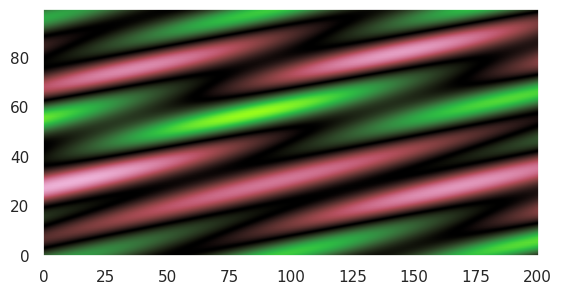

In [6]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.01
DISPERSIVITY = 0.01

# dispersion_stepper = ex.stepper.Dispersion(
#     1, DOMAIN_EXTENT, NUM_POINTS, DT, dispersivity=DISPERSIVITY
# )
dispersion_stepper = ex.normalized.DiffultyLinearStepperSimple(
    1, NUM_POINTS, difficulty=10, order=3
)

# grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
# u_0 = jnp.sin(2 * jnp.pi * grid / DOMAIN_EXTENT) + jnp.sin(
#     4 * jnp.pi * grid / DOMAIN_EXTENT
# )

u_0 = ex.ic.RandomTruncatedFourierSeries(
    1,
)(NUM_POINTS, key=jax.random.PRNGKey(0))

dispersion_trj_1d = ex.rollout(dispersion_stepper, time_steps_1d, include_init=True)(
    u_0
)

vmin, vmax = symmetric_min_max(dispersion_trj_1d)
plt.imshow(
    dispersion_trj_1d[:, 0, :].T,
    origin="lower",
    cmap=cmap_linear,
    interpolation="bilinear",
    vmin=vmin,
    vmax=vmax,
)
plt.grid(False)

### Burgers

$$ \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

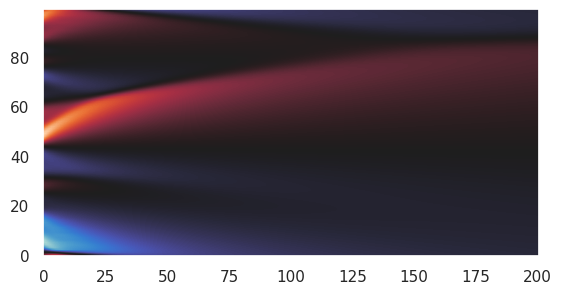

In [7]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.003
NU = 0.01

burgers_stepper = ex.stepper.Burgers(1, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU)

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
# u_0 = jnp.sin(4 * jnp.pi * grid / DOMAIN_EXTENT) + 0.5
u_0 = ex.ic.RandomTruncatedFourierSeries(1, cutoff=10)(
    NUM_POINTS, key=jax.random.PRNGKey(1)
)

burgers_trj_1d = ex.rollout(burgers_stepper, time_steps_1d, include_init=True)(u_0)

vmin, vmax = symmetric_min_max(burgers_trj_1d)
plt.imshow(
    burgers_trj_1d[:, 0, :].T,
    origin="lower",
    cmap=cmap_nonlinear,
    interpolation="bilinear",
    vmin=vmin,
    vmax=vmax,
)
plt.grid(False)

### Korteweg-de Vries (KdV)

$$ \frac{\partial u}{\partial t} - \frac{6}{2} \frac{\partial u^2}{\partial x} + \frac{\partial^3 u}{\partial x^3} = 0 $$

negative (and scaled) convection

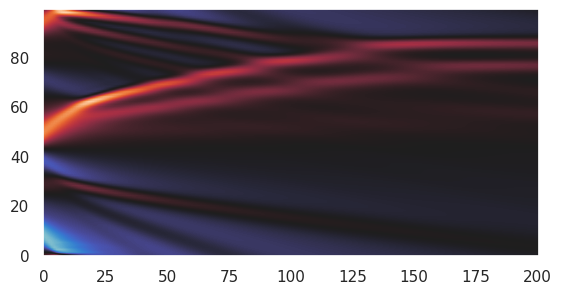

In [79]:
DOMAIN_EXTENT = 30.0
NUM_POINTS = 100
DT = 0.0

# Check documentation, the KdV stepper used "-6/2" convection scale by default
# to admit simple soliton solutions
# ks_stepper = ex.stepper.KortewegDeVries(1, DOMAIN_EXTENT, NUM_POINTS, DT)
kdv_stepper = ex.normalized.DifficultyGeneralNonlinearStepper(
    1,
    NUM_POINTS,
    linear_difficulties=(-0.0, -0.0, -0.0, -1.40, -0.50),
    nonlinear_difficulties=(-0.0, -0.40, -0.0),
)

# grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
# u_0 = jnp.cos(5 * jnp.pi * grid / DOMAIN_EXTENT)
u_0 = ex.ic.RandomTruncatedFourierSeries(1, cutoff=6)(
    NUM_POINTS, key=jax.random.PRNGKey(1)
)

kdv_trj_1d = ex.rollout(kdv_stepper, time_steps_1d, include_init=True)(u_0)

vmin, vmax = symmetric_min_max(kdv_trj_1d)
plt.imshow(
    kdv_trj_1d[:, 0, :].T,
    origin="lower",
    cmap=cmap_nonlinear,
    interpolation="bilinear",
    vmin=vmin,
    vmax=vmax,
)
plt.grid(False)

### Kuramoto-Sivashinsky (KS)

$$ \frac{\partial u}{\partial t} + \frac{1}{2} \left(\frac{\partial u}{\partial x}\right)^2 + \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4} = 0 $$

Format used in combustion research.

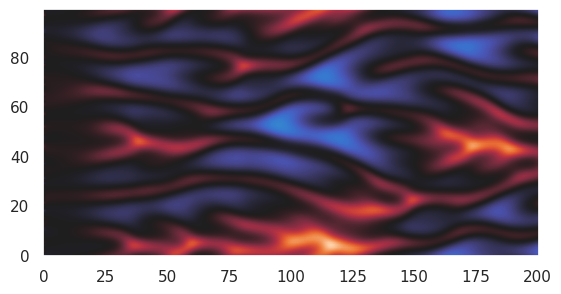

In [9]:
DOMAIN_EXTENT = 60.0
NUM_POINTS = 100
DT = 0.5

ks_stepper = ex.stepper.KuramotoSivashinsky(1, DOMAIN_EXTENT, NUM_POINTS, DT)

u_0 = jax.random.normal(
    jax.random.PRNGKey(0),
    (
        1,
        NUM_POINTS,
    ),
)  # IC is irrelevant

ks_trj_1d = ex.rollout(ks_stepper, time_steps_1d, include_init=True)(u_0)

vmin, vmax = symmetric_min_max(ks_trj_1d)
plt.imshow(
    ks_trj_1d[:, 0, :].T,
    origin="lower",
    cmap=cmap_nonlinear,
    interpolation="bilinear",
    vmin=vmin,
    vmax=vmax,
)
plt.grid(False)

### Kuramoto-Sivashinsky (KS) Conservative

$$ \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u^2}{\partial x} + \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4} = 0 $$

conservative format used in fluid dynamics

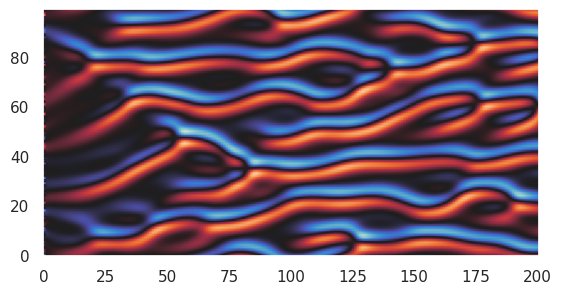

In [10]:
DOMAIN_EXTENT = 60.0
NUM_POINTS = 100
DT = 0.5

conservative_ks_stepper = ex.stepper.KuramotoSivashinskyConservative(
    1, DOMAIN_EXTENT, NUM_POINTS, DT
)

u_0 = jax.random.normal(
    jax.random.PRNGKey(0),
    (
        1,
        NUM_POINTS,
    ),
)  # IC is irrelevant

conservative_ks_trj_1d = ex.rollout(
    conservative_ks_stepper, time_steps_1d, include_init=True
)(u_0)

vmin, vmax = symmetric_min_max(conservative_ks_trj_1d)
plt.imshow(
    conservative_ks_trj_1d[:, 0, :].T,
    origin="lower",
    cmap=cmap_nonlinear,
    vmin=vmin,
    vmax=vmax,
)
plt.grid(False)

# 2D Cases

In [11]:
time_steps_2d = 200

In [12]:
from matplotlib.colors import Colormap, LinearSegmentedColormap, ListedColormap
import copy


def triangle_wave(x, p):
    return 2 * np.abs(x / p - np.floor(x / p + 0.5))


def felix_cmap_hack(cmap: Colormap) -> Colormap:
    """changes the alpha channel of a colormap to be diverging (0->1, 0.5 > 0, 1->1)

    Args:
        cmap (Colormap): colormap

    Returns:
        Colormap: new colormap
    """
    if isinstance(cmap, ListedColormap):
        colors = copy.deepcopy(cmap.colors)
        for i, a in enumerate(colors):
            a.append(2 * abs(i / cmap.N - 0.5))
        return ListedColormap(colors, cmap.name)
    elif isinstance(cmap, LinearSegmentedColormap):
        segmentdata = copy.deepcopy(cmap._segmentdata)
        segmentdata["alpha"] = np.array(
            [[0.0, 1.0, 1.0], [0.5, 0.0, 0.0], [1.0, 1.0, 1.0]]
        )
        return LinearSegmentedColormap(cmap.name, segmentdata)
    else:
        raise TypeError(
            "cmap must be either a ListedColormap or a LinearSegmentedColormap"
        )


def simon_cmap_hack(cmap):
    """changes the alpha channel of a colormap to be linear (0->0, 1->1)

    Args:
        cmap (Colormap): colormap

    Returns:
        Colormap: new colormap
    """
    if isinstance(cmap, ListedColormap):
        colors = copy.deepcopy(cmap.colors)
        for i, a in enumerate(colors):
            a.append(i / (cmap.N - 1))
        return ListedColormap(colors, cmap.name)
    elif isinstance(cmap, LinearSegmentedColormap):
        segmentdata = copy.deepcopy(cmap._segmentdata)
        segmentdata["alpha"] = np.array([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])
        return LinearSegmentedColormap(cmap.name, segmentdata)
    else:
        raise TypeError(
            "cmap must be either a ListedColormap or a LinearSegmentedColormap"
        )


def zigzag_alpha(cmap, min_alpha=0.2):
    """changes the alpha channel of a colormap to be linear (0->0, 1->1)

    Args:
        cmap (Colormap): colormap

    Returns:a
        Colormap: new colormap
    """
    if isinstance(cmap, ListedColormap):
        colors = copy.deepcopy(cmap.colors)
        for i, a in enumerate(colors):
            a.append(
                (triangle_wave(i / (cmap.N - 1), 0.5) * (1 - min_alpha)) + min_alpha
            )
        return ListedColormap(colors, cmap.name)
    elif isinstance(cmap, LinearSegmentedColormap):
        segmentdata = copy.deepcopy(cmap._segmentdata)
        segmentdata["alpha"] = np.array(
            [
                [0.0, 0.0, 0.0],
                [0.25, 1.0, 1.0],
                [0.5, 0.0, 0.0],
                [0.75, 1.0, 1.0],
                [1.0, 0.0, 0.0],
            ]
        )
        return LinearSegmentedColormap(cmap.name, segmentdata)
    else:
        raise TypeError(
            "cmap must be either a ListedColormap or a LinearSegmentedColormap"
        )

### Anisotropic Diffusion

In [59]:
def render_2d_st(volume, cmap, vrange=None):
    if vrange is None:
        vmin, vmax = symmetric_min_max(volume)
    else:
        vmin, vmax = -vrange, vrange
    img = render(
        np.flip(np.array(volume.transpose(1, 2, 3, 0)), 3),
        (cmap),
        time=0,
        background=(255, 255, 255, 255),
        distance_scale=10,
        vmin=vmin,
        vmax=vmax,
    )
    # gamma correction
    return np.power(img / 255.0, 2.4)

$$
\frac{\partial u}{\partial t} = \nabla \cdot \left( A \nabla u \right)
$$

(-0.5, 1023.5, 1023.5, -0.5)

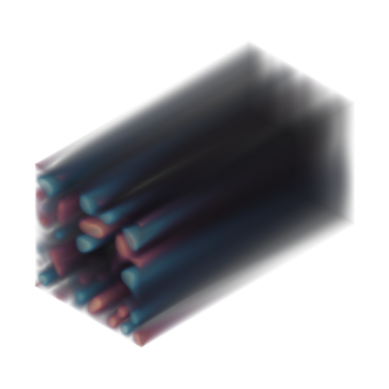

In [14]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.002
# Can also supply a 2d vector for diagonal diffusivity. For full anisotropy, the
# matrix must be positive definite.
NU = jnp.array([[0.005, 0.003], [0.003, 0.04]])

anisotropic_diffusion_stepper = ex.stepper.Diffusion(
    2, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU
)

# grid = ex.make_grid(2, DOMAIN_EXTENT, NUM_POINTS)
# u_0 = jnp.sin(2 * jnp.pi * grid[0:1] / DOMAIN_EXTENT) * jnp.cos(
#     2 * 2 * jnp.pi * grid[1:2] / DOMAIN_EXTENT
# )
u_0 = ex.ic.RandomTruncatedFourierSeries(2, cutoff=5)(
    NUM_POINTS, key=jax.random.PRNGKey(0)
)

anisotropic_diffusion_trj_2d = ex.rollout(
    anisotropic_diffusion_stepper, time_steps_2d, include_init=True
)(u_0)


anisotropic_diffusion_img = render_2d_st(
    anisotropic_diffusion_trj_2d, zigzag_alpha(cmap_diff, 0.1)
)
plt.imshow(anisotropic_diffusion_img)
plt.axis("off")

### Burgers

$$
\frac{\partial u}{\partial t} + \frac{1}{2} \nabla \cdot \left( u \otimes u \right) = \nu \Delta u
$$

(-0.5, 1023.5, 1023.5, -0.5)

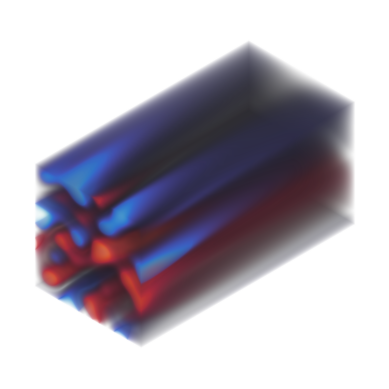

In [15]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.005
NU = 0.01

burgers_stepper = ex.stepper.Burgers(2, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU)

grid = ex.make_grid(2, DOMAIN_EXTENT, NUM_POINTS)

# Burgers has two channels!
# u_0 = jnp.concatenate(
#     [
#         jnp.sin(2 * jnp.pi * grid[0:1] / DOMAIN_EXTENT)
#         * jnp.cos(2 * 2 * jnp.pi * grid[1:2] / DOMAIN_EXTENT),
#         jnp.cos(2 * jnp.pi * grid[0:1] / DOMAIN_EXTENT)
#         * jnp.sin(2 * 2 * jnp.pi * grid[1:2] / DOMAIN_EXTENT),
#     ]
# )
ic_gen = ex.ic.RandomTruncatedFourierSeries(2, cutoff=3, max_one=True)
multi_channel_ic_gen = ex.ic.RandomMultiChannelICGenerator([ic_gen, ic_gen])
u_0 = multi_channel_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

burgers_trj_2d = ex.rollout(burgers_stepper, time_steps_2d, include_init=True)(u_0)

burgers_img = render_2d_st(burgers_trj_2d, zigzag_alpha(cmap_nonlinear, 0.1))
plt.imshow(burgers_img)
plt.axis("off")

### Kuramoto-Sivashinsky (KS)

The combustion format (using the gradient norm) generalizes nicely to higher dimensions

$$
\frac{\partial u}{\partial t} + \frac{1}{2} \| \nabla u \|_2^2 + \Delta u + \Delta^2 u = 0
$$

(-0.5, 1023.5, 1023.5, -0.5)

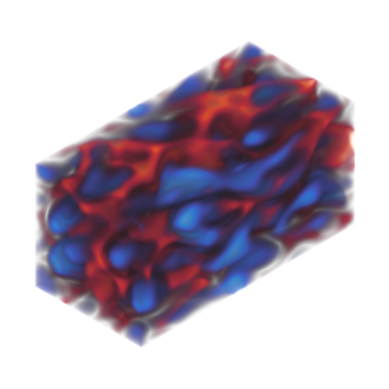

In [16]:
DOMAIN_EXTENT = 30.0
NUM_POINTS = 100
DT = 0.2

ks_stepper = ex.stepper.KuramotoSivashinsky(2, DOMAIN_EXTENT, NUM_POINTS, DT)

grid = ex.make_grid(2, DOMAIN_EXTENT, NUM_POINTS)


# IC is irrelevant
u_0 = jax.random.normal(jax.random.PRNGKey(0), (1, NUM_POINTS, NUM_POINTS))

warmed_up_u_0 = ex.repeat(ks_stepper, 500)(u_0)

ks_trj_2d = ex.rollout(ks_stepper, time_steps_2d, include_init=True)(warmed_up_u_0)

ks_img = render_2d_st(ks_trj_2d, zigzag_alpha(cmap_nonlinear, 0.1))
plt.imshow(ks_img)
plt.axis("off")

### Gray-Scott

$$
\begin{aligned}
\frac{\partial u_0}{\partial t} &= \nu_0 \Delta u_0 - u_0 u_1^2 + f (1 - u_0) \\
\frac{\partial u_1}{\partial t} &= \nu_1 \Delta u_1 + u_0 u_1^2 - (f + k) u_1
\end{aligned}
$$

Text(0.5, 1.0, 'Channel 2')

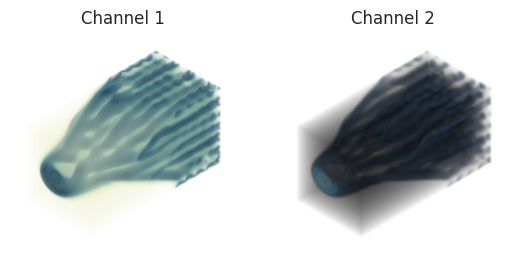

In [17]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 30.0
DIFFUSIVITY_0 = 2e-5
DIFFUSIVITY_1 = 1e-5
FEED_RATE = 0.02
KILL_RATE = 0.056

gray_scott_stepper = ex.RepeatedStepper(
    ex.reaction.GrayScott(
        2,
        DOMAIN_EXTENT,
        NUM_POINTS,
        DT / 30,
        diffusivity_1=DIFFUSIVITY_0,
        diffusivity_2=DIFFUSIVITY_1,
        feed_rate=FEED_RATE,
        kill_rate=KILL_RATE,
    ),
    15,
)

u_0 = ex.ic.RandomMultiChannelICGenerator(
    [
        ex.ic.RandomGaussianBlobs(2, one_complement=True),
        ex.ic.RandomGaussianBlobs(2),
    ]
)(NUM_POINTS, key=jax.random.PRNGKey(0))

gray_scott_trj_2d = ex.rollout(gray_scott_stepper, time_steps_2d, include_init=True)(
    u_0
)


gray_scott_img_1 = render_2d_st(gray_scott_trj_2d[:, :1], zigzag_alpha(cmap_diff, 0.1))
gray_scott_img_2 = render_2d_st(gray_scott_trj_2d[:, 1:], zigzag_alpha(cmap_diff, 0.1))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(gray_scott_img_1)
ax1.axis("off")
ax1.set_title("Channel 1")
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(gray_scott_img_2)
ax2.axis("off")
ax2.set_title("Channel 2")

### Kolmogorow Flow

Uses streamline vorticity formulation

$$
\frac{\partial u}{\partial t} + \left( \begin{bmatrix} 1 \\ -1 \end{bmatrix} \odot \nabla (\Delta^{-1} u)\right) \cdot \nabla u = \lambda u + \nu \Delta u + f
$$

with a forcing on a specific mode over y direction

(-0.5, 1023.5, 1023.5, -0.5)

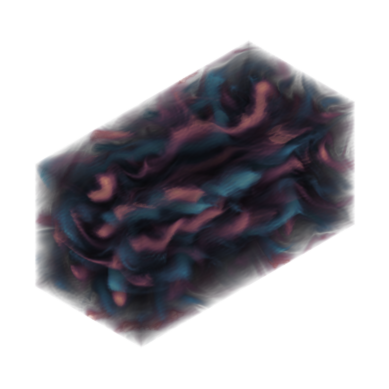

In [18]:
DOMAIN_EXTENT = 2 * jnp.pi
NUM_POINTS = 100
DT = 0.1
NU = 0.001
DRAG = -0.1
INJECTION_MODE = 4
INJECTION_SCALE = 1.0

kolmogorow_flow_ns_stepper = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVorticity(
        2,
        DOMAIN_EXTENT,
        NUM_POINTS,
        DT / 100,
        diffusivity=NU,
        drag=DRAG,
        injection_mode=INJECTION_MODE,
        injection_scale=INJECTION_SCALE,
    ),
    100,
)

u_0 = ex.ic.DiffusedNoise(2, max_one=True, zero_mean=True)(
    NUM_POINTS, key=jax.random.PRNGKey(0)
)

warmed_up_u_0 = ex.repeat(kolmogorow_flow_ns_stepper, 500)(u_0)

kolmogorow_flow_ns_trj_2d = ex.rollout(
    kolmogorow_flow_ns_stepper, time_steps_2d, include_init=True
)(warmed_up_u_0)

kolmogorow_flow_ns_img = render_2d_st(
    kolmogorow_flow_ns_trj_2d, zigzag_alpha(cmap_diff)
)
plt.imshow(kolmogorow_flow_ns_img)
plt.axis("off")

## 3D plots


In [27]:
def render_3d(volume, cmap, time=0.1, vrange=None):
    if vrange is None:
        vmin, vmax = symmetric_min_max(volume)
    else:
        vmin, vmax = -vrange, vrange

    img = render(
        np.array(volume),
        (cmap),
        time=time,
        background=(255, 255, 255, 255),
        distance_scale=10,
        vmin=vmin,
        vmax=vmax,
    )
    # gamma correction
    return np.power(img / 255.0, 2.4)

## Unbalanced Advection

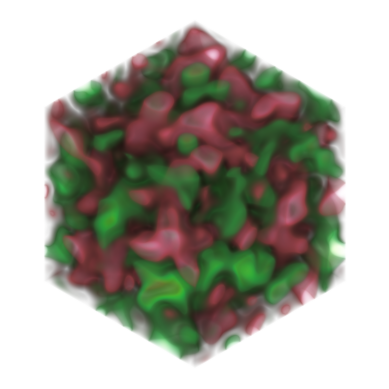

In [35]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 64
DT = 0.01
VELOCITY = 1.0

advection_stepper = ex.stepper.Advection(
    3,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    velocity=np.array([VELOCITY * 2, VELOCITY * 0.4, VELOCITY]),
)

u_0 = ex.ic.DiffusedNoise(3, max_one=True, zero_mean=True)(
    NUM_POINTS, key=jax.random.PRNGKey(0)
)
advection_trj_3d = ex.rollout(advection_stepper, 64, include_init=True)(u_0)

advection_trj_3d_img = render_3d(
    advection_trj_3d[:, 0], zigzag_alpha(cmap_linear, 0.1), vrange=0.5
)
plt.imshow(advection_trj_3d_img)
plt.axis("off")
del advection_trj_3d

### Burgers

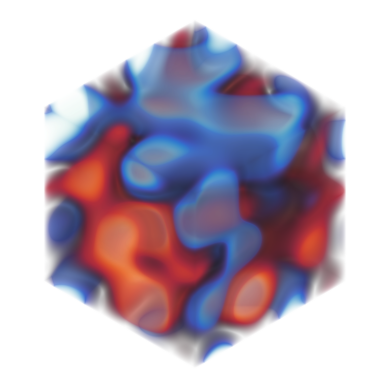

In [37]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 64
DT = 0.01
NU = 0.01

burgers_stepper = ex.stepper.Burgers(3, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU)

grid = ex.make_grid(3, DOMAIN_EXTENT, NUM_POINTS)

# Burgers has two channels!
# u_0 = jnp.concatenate(
#     [
#         jnp.sin(2 * jnp.pi * grid[0:1] / DOMAIN_EXTENT)
#         * jnp.cos(2 * 2 * jnp.pi * grid[1:2] / DOMAIN_EXTENT),
#         jnp.cos(2 * jnp.pi * grid[1:2] / DOMAIN_EXTENT)
#         * jnp.sin(2 * 2 * jnp.pi * grid[2:3] / DOMAIN_EXTENT),
#         jnp.cos(2 * jnp.pi * grid[2:3] / DOMAIN_EXTENT)
#         * jnp.sin(2 * 2 * jnp.pi * grid[0:1] / DOMAIN_EXTENT),
#     ]
# )
ic_gen = ex.ic.RandomTruncatedFourierSeries(3, cutoff=2, max_one=True)
multi_channel_ic_gen = ex.ic.RandomMultiChannelICGenerator([ic_gen, ic_gen, ic_gen])
u_0 = multi_channel_ic_gen(NUM_POINTS, key=jax.random.PRNGKey(1))

burgers_trj_3d = ex.rollout(burgers_stepper, 64, include_init=True)(u_0)

burgers_trj_3d_img = render_3d(
    burgers_trj_3d[:, 0], zigzag_alpha(cmap_nonlinear, 0.1), vrange=0.4
)
plt.imshow(burgers_trj_3d_img)
plt.axis("off")
del burgers_trj_3d

## KS (Combustion)

(-0.5, 1023.5, 1023.5, -0.5)

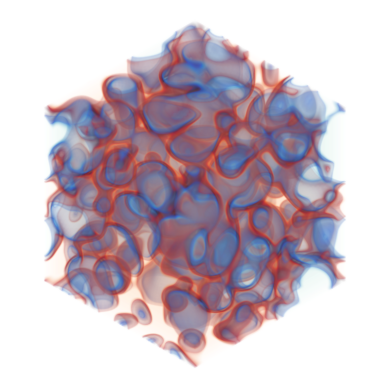

In [40]:
DOMAIN_EXTENT = 30.0
NUM_POINTS = 64
DT = 0.1

ks_stepper = ex.stepper.KuramotoSivashinsky(3, DOMAIN_EXTENT, NUM_POINTS, DT)

# IC is irrelevant
u_0 = jax.random.normal(jax.random.PRNGKey(0), (1, NUM_POINTS, NUM_POINTS, NUM_POINTS))
warmed_up_u_0 = ex.repeat(ks_stepper, 500)(u_0)
ks_trj_3d = ex.rollout(ks_stepper, 64, include_init=True)(warmed_up_u_0)
ks_img_3d = render_3d(ks_trj_3d[:, 0], zigzag_alpha(cmap_nonlinear, 0.1), vrange=3.0)
plt.imshow(ks_img_3d)
plt.axis("off")

## Gray Scott

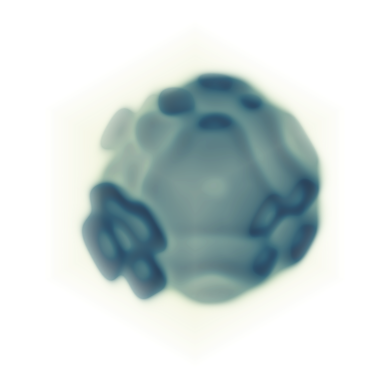

In [48]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 64
DT = 30.0
DIFFUSIVITY_0 = 2e-5
DIFFUSIVITY_1 = 1e-5
FEED_RATE = 0.04
KILL_RATE = 0.06

gray_scott_stepper = ex.RepeatedStepper(
    ex.reaction.GrayScott(
        3,
        DOMAIN_EXTENT,
        NUM_POINTS,
        DT / 30,
        diffusivity_1=DIFFUSIVITY_0,
        diffusivity_2=DIFFUSIVITY_1,
        feed_rate=FEED_RATE,
        kill_rate=KILL_RATE,
    ),
    15,
)

u_0 = ex.ic.RandomMultiChannelICGenerator(
    [
        ex.ic.RandomGaussianBlobs(3, one_complement=True, num_blobs=1),
        ex.ic.RandomGaussianBlobs(3, num_blobs=1),
    ]
)(NUM_POINTS, key=jax.random.PRNGKey(0))

gray_scott_trj_3d = ex.rollout(gray_scott_stepper, 128, include_init=True)(u_0)


gray_scott_img_3d = render_3d(
    gray_scott_trj_3d[:, 0], zigzag_alpha(cmap_diff, 0.1), time=0.8
)
plt.imshow(gray_scott_img_3d)
plt.axis("off")
del gray_scott_trj_3d

## Swift-Hohenberg

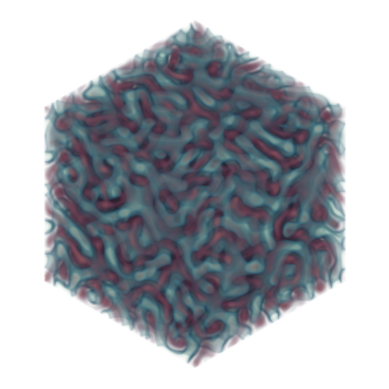

In [51]:
DOMAIN_EXTENT = 20.0 * jnp.pi
NUM_POINTS = 64
DT = 1.0

swift_hohenberg_stepper = ex.RepeatedStepper(
    ex.reaction.SwiftHohenberg(3, DOMAIN_EXTENT, NUM_POINTS, DT / 10),
    10,
)

u_0 = ex.ic.RandomTruncatedFourierSeries(3, max_one=True)(
    NUM_POINTS, key=jax.random.PRNGKey(0)
)

swift_hohenberg_trj_3d = ex.rollout(swift_hohenberg_stepper, 40, include_init=True)(u_0)

swift_hohenberg_img_3d = render_3d(
    swift_hohenberg_trj_3d[:, 0], zigzag_alpha(cmap_diff, 0.1), time=0.4, vrange=1.7
)
plt.imshow(swift_hohenberg_img_3d)
plt.axis("off")
del swift_hohenberg_trj_3d

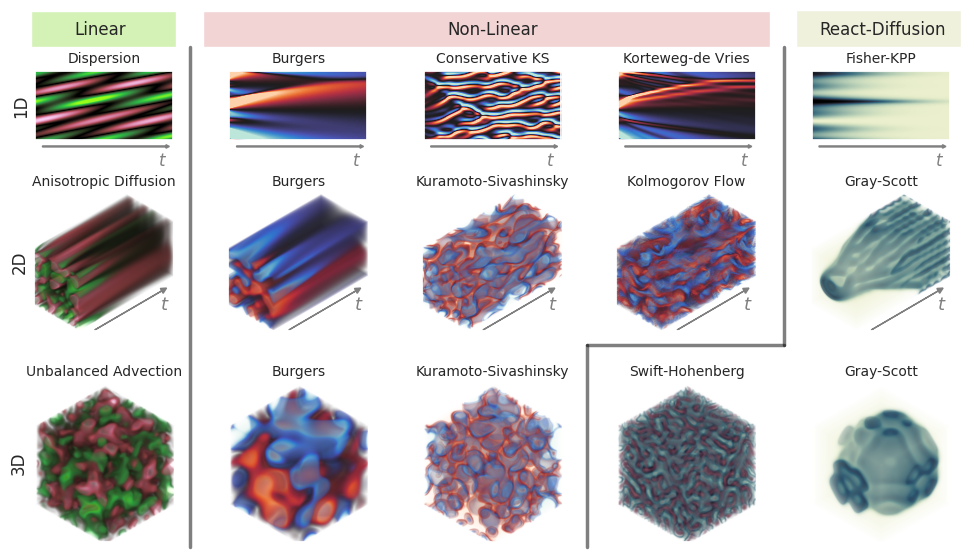

In [87]:
from matplotlib.patches import FancyArrow

fig, axes = plt.subplots(
    3, 5, figsize=(10, 5), gridspec_kw={"height_ratios": [1, 2, 2.3]}
)


samples_1d = {
    "Dispersion": {"trj": dispersion_trj_1d, "type": "linear", "vrange": 1.3},
    "Burgers": {"trj": burgers_trj_1d, "type": "nonlinear", "vrange": 1.0},
    "Conservative KS": {
        "trj": conservative_ks_trj_1d,
        "type": "nonlinear",
        "vrange": 2.0,
    },
    "Korteweg-de Vries": {"trj": kdv_trj_1d, "type": "nonlinear", "vrange": 1.5},
    "Fisher-KPP": {"trj": fisher_kpp_trj_1d, "type": "diffusion", "vrange": None},
    # "Kuramoto-Sivashinsky (KS)": {"trj":ks_trj_1d,"type":"nonlinear"},
}

samples_2d = {
    "Anisotropic Diffusion": {
        "trj": anisotropic_diffusion_trj_2d,
        "type": "linear",
        "vrange": 2.0,
    },
    "Burgers": {"trj": burgers_trj_2d, "type": "nonlinear", "vrange": 0.6},
    "Kuramoto-Sivashinsky": {"trj": ks_trj_2d, "type": "nonlinear", "vrange": 3.0},
    "Kolmogorov Flow": {
        "trj": kolmogorow_flow_ns_trj_2d,
        "type": "nonlinear",
        "vrange": 8.0,
    },
    "Gray-Scott": {
        "trj": gray_scott_trj_2d[:, :1],
        "type": "diffusion",
        "vrange": None,
    },
}


samples_3d = {
    "Unbalanced Advection": {"img": advection_trj_3d_img, "type": "linear"},
    "Burgers": {"img": burgers_trj_3d_img, "type": "nonlinear"},
    "Kuramoto-Sivashinsky": {"img": ks_img_3d, "type": "nonlinear"},
    "Swift-Hohenberg": {"img": swift_hohenberg_img_3d, "type": "diffusion"},
    "Gray-Scott": {"img": gray_scott_img_3d, "type": "diffusion"},
}


def get_cmap(sim_type):
    if sim_type == "linear":
        return cmap_linear
    elif sim_type == "nonlinear":
        return cmap_nonlinear
    elif sim_type == "diffusion":
        return cmap_diff
    else:
        raise ValueError("Invalid simulation type")


for i, (name, trj) in enumerate(samples_1d.items()):
    ax = axes[0][i]
    if trj["vrange"] is None:
        vmin, vmax = symmetric_min_max(trj["trj"])
    else:
        vmin, vmax = -trj["vrange"], trj["vrange"]
    ax.imshow(
        trj["trj"][:, 0, :].T,
        origin="lower",
        cmap=get_cmap(trj["type"]),
        interpolation="bilinear",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(name, fontsize=10)
    # ax.axis("off")
    ax.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])

    ax.add_patch(
        FancyArrow(
            10,
            -10,
            180,
            0,
            color="grey",
            width=1.5,
            head_width=5,
            head_length=5,
            clip_on=False,
        )
    )
    ax.text(
        185, -18, "$t$", color="grey", fontsize=12, ha="center", va="top", clip_on=False
    )

    if i == 0:
        ax.set_ylabel("1D", fontsize=12)

for i, (name, trj) in enumerate(samples_2d.items()):
    ax = axes[1][i]

    render_img = render_2d_st(
        trj["trj"], zigzag_alpha(get_cmap(trj["type"]), 0.1), vrange=trj["vrange"]
    )
    # apply gamma correction
    ax.imshow(render_img[80:940, 80:960])

    ax.set_title(name, fontsize=10)
    ax.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.add_patch(
        FancyArrow(
            380,
            855,
            420,
            -245,
            color="grey",
            width=0.05,
            head_width=35,
            head_length=35,
            clip_on=False,
        )
    )
    ax.text(820, 750, "$t$", color="grey", fontsize=13, ha="center", va="bottom")
    if i == 0:
        ax.set_ylabel("2D", fontsize=12)

for i, (name, trj) in enumerate(samples_3d.items()):
    ax = axes[2][i]
    ax.imshow(trj["img"][20:980, 80:940], interpolation="bilinear")
    ax.set_title(name, fontsize=10)
    # ax.axis("off")
    ax.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("3D", fontsize=12)
plt.tight_layout(pad=0.3)


import matplotlib.transforms as mtrans

r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = list(map(get_bbox, axes.flat))

# Get the minimum and maximum extent, get the coordinate half-way between those
xmax = np.array(list(map(lambda b: b.x1, bboxes))).reshape(axes.shape).max(axis=0)
xmin = np.array(list(map(lambda b: b.x0, bboxes))).reshape(axes.shape).min(axis=0)
xs = np.c_[xmax[1:], xmin[:-1]].mean(axis=1)


line = plt.Line2D(
    [xs[2], xs[3]],
    [0.405, 0.405],
    transform=fig.transFigure,
    color=(0, 0, 0, 0.5),
    linewidth=2.5,
)
fig.add_artist(line)

# Draw a horizontal lines at those coordinates
for i, x in enumerate(xs):
    if i == 1:
        continue
    y_0 = 0 if i != 3 else 0.405
    y_1 = 1
    if i == 2:
        y_1 = 0.405
    line = plt.Line2D(
        [x, x],
        [y_0, y_1],
        transform=fig.transFigure,
        color=(0, 0, 0, 0.5),
        linewidth=2.5,
    )
    fig.add_artist(line)

fig.add_artist(
    patches.Rectangle(
        (0.05, 1.0),
        0.145,
        0.0725,
        facecolor="#d4f2b6",
    )
)
fig.add_artist(
    patches.Rectangle(
        (0.2215, 1.0),
        0.5675,
        0.0725,
        facecolor="#f2d4d4",
    )
)
fig.add_artist(
    patches.Rectangle(
        (0.815, 1.0),
        0.165,
        0.075,
        facecolor="#f0f1dc",
    )
)
fig.add_artist(
    plt.Text(
        (0.03 + xs[0]) / 2, 1.0175, "Linear", ha="center", va="bottom", fontsize=12
    )
)
fig.add_artist(
    plt.Text(
        (xs[1] + xs[2]) / 2, 1.0175, "Non-Linear", ha="center", va="bottom", fontsize=12
    )
)
fig.add_artist(
    plt.Text(
        (xs[3] + 1) / 2,
        1.0175,
        "React-Diffusion",
        ha="center",
        va="bottom",
        fontsize=12,
    )
)

plt.savefig("teaser_new.pdf", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [26]:
xs

array([0.20841093, 0.41736202, 0.60541486, 0.80258817])